In [1]:
import os, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.core.util import event_pb2
import pandas as pd
import numpy as np
from pathlib import Path

def read_tensorboard_logs(log_dir):
    """
    Read TensorBoard event files and extract metrics.
    
    Parameters:
    - log_dir: Path to directory containing TensorBoard event files
    
    Returns:
    - metrics_df: DataFrame with columns [step, epoch, metric_name, value]
    """
    log_path = Path(log_dir)
    event_files = list(log_path.glob("events.out.tfevents.*"))
    
    if not event_files:
        raise ValueError(f"No TensorBoard event files found in {log_dir}")
    
    all_metrics = []
    
    for event_file in event_files:
        for record in tf.data.TFRecordDataset(str(event_file)):
            event = event_pb2.Event.FromString(record.numpy())
            
            # Extract scalar values
            for value in event.summary.value:
                all_metrics.append({
                    'step': event.step,
                    'wall_time': event.wall_time,
                    'metric_name': value.tag,
                    'value': value.simple_value
                })
    
    metrics_df = pd.DataFrame(all_metrics)
    return metrics_df

def calculate_saturation_point(metrics_df, metric_name='train/loss', threshold_pct=0.1):
    """
    Calculate the first step where the model reaches within threshold_pct of final loss.
    
    Parameters:
    - metrics_df: DataFrame from read_tensorboard_logs
    - metric_name: Name of the metric to analyze (e.g., 'train/loss')
    - threshold_pct: Percentage threshold (default 0.1 for 10%)
    
    Returns:
    - saturation_dict: Dictionary with saturation metrics
    """
    # Filter for the specific metric
    metric_data = metrics_df[metrics_df['metric_name'] == metric_name].copy()
    metric_data = metric_data.sort_values('step')
    
    if len(metric_data) == 0:
        raise ValueError(f"Metric '{metric_name}' not found in data")
    
    # Get final loss value (average of last 10% of training)
    n_final = max(1, len(metric_data) // 10)
    final_loss = metric_data['value'].tail(n_final).mean()
    
    # Get initial loss
    initial_loss = metric_data['value'].iloc[0]
    
    # Calculate threshold value
    threshold_value = final_loss * (1 + threshold_pct)
    
    # Find first step where loss is within threshold of final value
    within_threshold = metric_data[metric_data['value'] <= threshold_value]
    
    if len(within_threshold) == 0:
        saturation_step = None
        saturation_epoch = None
    else:
        saturation_step = within_threshold['step'].iloc[0]
        saturation_epoch = saturation_step  # Adjust if you track epochs separately
    
    return {
        'saturation_step': saturation_step,
        'initial_loss': initial_loss,
        'final_loss': final_loss,
        'threshold_value': threshold_value,
        'total_steps': metric_data['step'].max(),
        'saturation_pct': (saturation_step / metric_data['step'].max() * 100) if saturation_step else None
    }

def extract_all_metrics(log_dir, output_csv=None):
    """
    Extract all metrics and calculate saturation for train/val loss.
    
    Parameters:
    - log_dir: Path to TensorBoard log directory
    - output_csv: Optional path to save metrics CSV
    
    Returns:
    - metrics_df: DataFrame with all metrics
    - saturation_metrics: Dictionary with saturation analysis
    """
    # Read metrics
    metrics_df = read_tensorboard_logs(log_dir)
    
    # Save to CSV if requested
    if output_csv:
        metrics_df.to_csv(output_csv, index=False)
        print(f"Metrics saved to {output_csv}")
    
    # Calculate saturation for different metrics
    saturation_metrics = {}
    
    for metric_name in ['train_loss']:
        try:
            saturation = calculate_saturation_point(metrics_df, metric_name)
            saturation_metrics[metric_name] = saturation
            print(f"\n{metric_name}:")
            print(f"  Saturation step: {saturation['saturation_step']}")
            print(f"  Saturation at: {saturation['saturation_pct']:.1f}% of training")
            print(f"  Initial loss: {saturation['initial_loss']:.4f}")
            print(f"  Final loss: {saturation['final_loss']:.4f}")
        except ValueError:
            continue
    
    return metrics_df, saturation_metrics

# # Usage example
# log_dir = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-22_15-59-22/0_boli_qual_high_amt_high/tensorboard/version_0"
# metrics_df, saturation_metrics = extract_all_metrics(
#     log_dir, 
#     output_csv="training_metrics.csv"
# )

2025-10-02 17:39:19.341634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/gpfs/home/asun/miniforge3/envs/perturbench/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/gpfs/home/asun/miniforge3/envs/perturbench/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibi

/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/0_boli_100225_qual_high_amt_high/evaluation/summary.csv


I0000 00:00:1759452007.591755    4479 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7498 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1
I0000 00:00:1759452007.604073    4479 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7498 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:81:00.0, compute capability: 6.1
2025-10-02 17:40:08.576953: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-10-02 17:40:08.844651: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-02 17:40:08.878099: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



train_loss:
  Saturation step: 259
  Saturation at: 9.7% of training
  Initial loss: 0.1753
  Final loss: 0.0517
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/1_boli_100225_qual_high_amt_low/evaluation/summary.csv


2025-10-02 17:40:09.108231: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



train_loss:
  Saturation step: 139
  Saturation at: 13.5% of training
  Initial loss: 0.1713
  Final loss: 0.0553
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/2_boli_100225_qual_high_amt_medium/evaluation/summary.csv

train_loss:
  Saturation step: 199
  Saturation at: 10.6% of training
  Initial loss: 0.1729
  Final loss: 0.0529
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/3_boli_100225_qual_low_amt_high/evaluation/summary.csv

train_loss:
  Saturation step: 209
  Saturation at: 38.8% of training
  Initial loss: 0.1802
  Final loss: 0.0531
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/4_boli_100225_qual_low_amt_low/evaluation/summary.csv


2025-10-02 17:40:09.553944: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



train_loss:
  Saturation step: 169
  Saturation at: 80.9% of training
  Initial loss: 0.1780
  Final loss: 0.0551
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/5_boli_100225_qual_low_amt_medium/evaluation/summary.csv

train_loss:
  Saturation step: 199
  Saturation at: 52.5% of training
  Initial loss: 0.1725
  Final loss: 0.0547
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/6_boli_100225_qual_medium_amt_high/evaluation/summary.csv

train_loss:
  Saturation step: 229
  Saturation at: 14.2% of training
  Initial loss: 0.1745
  Final loss: 0.0525
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/7_boli_100225_qual_medium_amt_low/evaluation/summary.csv


2025-10-02 17:40:10.467708: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



train_loss:
  Saturation step: 169
  Saturation at: 27.3% of training
  Initial loss: 0.1696
  Final loss: 0.0554
/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/8_boli_100225_qual_medium_amt_medium/evaluation/summary.csv

train_loss:
  Saturation step: 179
  Saturation at: 16.0% of training
  Initial loss: 0.1702
  Final loss: 0.0525


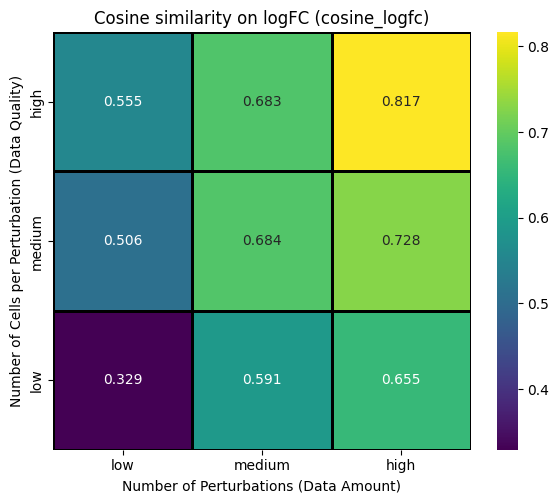

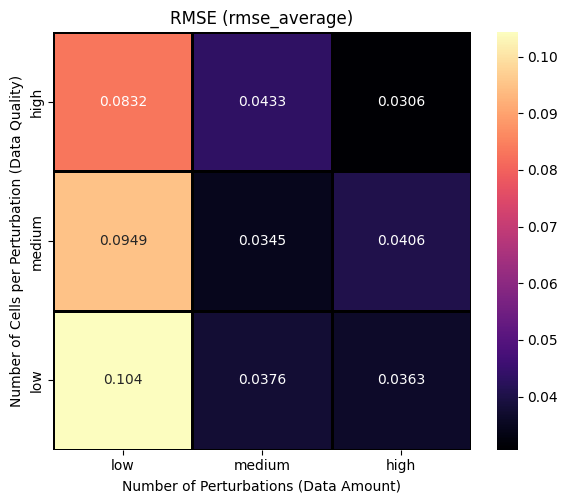

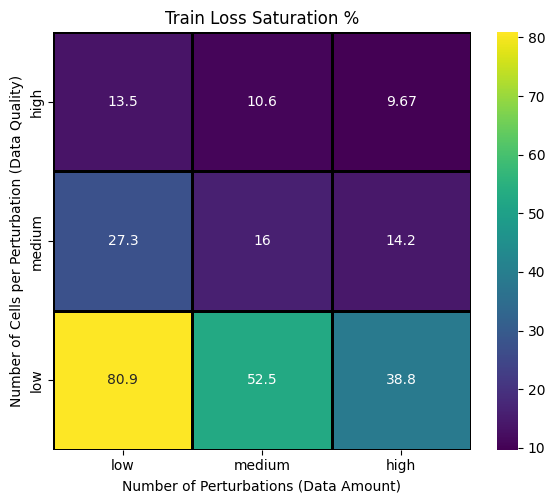

In [3]:
# --------- CONFIGURE YOUR GRID LABELS HERE ----------
x_labels = ["low", "medium", "high"]      # Training Data Amount (columns)
y_labels = ["high", "medium", "low"]      # Data Quality (rows)

# Path pattern (as you provided)
#PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/runs/*_boli*/evaluation/summary.csv"
#PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-22_15-59-22/*_boli*/"
#PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-22_17-13-37/*_replogle*/evaluation/summary.csv"
#PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/*_replogle*/"
#PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_18-22-55/*_simulated*/evaluation/summary.csv"
PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/*boli*/"
# Optional: if your run dirs encode amount/quality with these tokens; adjust if needed.
AMOUNT_RE  = re.compile(r"(?:amount|train|split|size|amt|data|cells)[-_]?(low|medium|high)", re.I)
QUALITY_RE = re.compile(r"(?:quality|qual|noise|q)[-_]?(low|medium|high)", re.I)

# --------- HELPERS ----------
def find_label_in_text(text, labels):
    """Return first matching label in `labels` found as whole word in text (case-insensitive)."""
    for lab in labels:
        if re.search(rf"\b{re.escape(lab)}\b", text, flags=re.I):
            return lab
    return None

def parse_xy_from_path(path):
    """
    Infer (x_amount, y_quality) from the run directory name.
    Tries explicit regex first; falls back to scanning labels in the path.
    """
    run_dir = os.path.dirname(path)
    print(path)
    base = os.path.basename(run_dir)

    m_amt = AMOUNT_RE.search(run_dir) or AMOUNT_RE.search(base)
    m_qual = QUALITY_RE.search(run_dir) or QUALITY_RE.search(base)

    x = (m_amt.group(1).lower() if m_amt else None)
    y = (m_qual.group(1).lower() if m_qual else None)

    # Fallbacks: try to spot labels anywhere in the path
    if x is None:
        x = find_label_in_text(run_dir, x_labels)
    if y is None:
        y = find_label_in_text(run_dir, y_labels)

    return x, y

# --------- LOAD CSVs & PLACE INTO MATRICES ----------
paths = sorted(glob.glob(PATTERN))

# Initialize matrices with NaN so missing cells remain blank
mat_cos = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)
mat_rmse = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)
mat_val_loss = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)
mat_train_loss = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)

for p in paths:
    log_path = p + "tensorboard/version_0"
    p = p + "evaluation/summary.csv"
    x, y = parse_xy_from_path(p)
    if (x not in x_labels) or (y not in y_labels):
        print(f"[warn] Could not map run to grid (x={x}, y={y}) for: {p}")
        continue

    df = pd.read_csv(p)
    # Expect a 2-column CSV like:
    # metric,LatentAdditive
    # rmse_average,0.1496
    # cosine_logfc,0.44
    if df.shape[1] < 2:
        print(f"[warn] Unexpected CSV shape for {p}: {df.shape}")
        continue

    value_col = df.columns[1]  # e.g., "LatentAdditive"
    sub = df.set_index("metric")[value_col]

    if "cosine_logfc" in sub.index:
        mat_cos.loc[y, x] = float(sub["cosine_logfc"])
    else:
        print(f"[warn] cosine_logfc missing in {p}")

    if "rmse_average" in sub.index:
        mat_rmse.loc[y, x] = float(sub["rmse_average"])
    else:
        print(f"[warn] rmse_average missing in {p}")

    metrics_df, saturation_metrics = extract_all_metrics(
        log_path
    )

    #mat_val_loss.loc[y, x] = saturation_metrics["val_loss_step"]["saturation_pct"]
    mat_train_loss.loc[y, x] = saturation_metrics["train_loss"]["saturation_pct"]

# --------- PLOT HEATMAPS ----------
def plot_heatmap(data, title, cmap="viridis", fmt=".3g"):
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        data,
        annot=True, fmt=fmt, linewidths=1, linecolor="black",
        square=True, cmap=cmap, cbar=True
    )
    ax.set_xlabel("Number of Perturbations (Data Amount)")
    ax.set_ylabel("Number of Cells per Perturbation (Data Quality)")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(mat_cos,  "Cosine similarity on logFC (cosine_logfc)")
plot_heatmap(mat_rmse, "RMSE (rmse_average)", cmap="magma")
plot_heatmap(mat_train_loss, "Train Loss Saturation %")
#plot_heatmap(mat_val_loss, "Val Loss Saturation %", cmap="magma")

#plot_heatmap()

In [5]:
paths = sorted(glob.glob(PATTERN))


In [10]:
y

'medium'

In [ ]:
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import your saturation calculation functions
from tbparse import SummaryReader

def calculate_saturation_point(metrics_df, metric_name='train_loss', threshold_pct=0.1):
    """Calculate the first step where the model reaches within threshold_pct of final loss."""
    metric_data = metrics_df[metrics_df['tag'] == metric_name].copy()
    metric_data = metric_data.sort_values('step')
    
    if len(metric_data) == 0:
        return None
    
    n_final = max(1, len(metric_data) // 10)
    final_loss = metric_data['value'].tail(n_final).mean()
    threshold_value = final_loss * (1 + threshold_pct)
    
    within_threshold = metric_data[metric_data['value'] <= threshold_value]
    
    if len(within_threshold) == 0:
        return None
    
    saturation_step = int(within_threshold['step'].iloc[0])
    total_steps = int(metric_data['step'].max())
    saturation_pct = (saturation_step / total_steps * 100)
    
    return saturation_pct

def get_saturation_from_run(run_dir):
    """Extract saturation percentage from a run's tensorboard logs."""
    # Look for tensorboard directory
    tb_dirs = list(Path(run_dir).glob("tensorboard/version_*"))
    
    if not tb_dirs:
        print(f"[warn] No tensorboard logs found in {run_dir}")
        return None
    
    # Use the first (or latest) version
    tb_dir = sorted(tb_dirs)[-1]
    
    try:
        reader = SummaryReader(str(tb_dir))
        metrics_df = reader.scalars
        
        # Try different metric names
        for metric_name in ['train_loss', 'train/loss', 'loss']:
            if metric_name in metrics_df['tag'].values:
                saturation_pct = calculate_saturation_point(metrics_df, metric_name)
                if saturation_pct is not None:
                    return saturation_pct
        
        print(f"[warn] No train loss metric found in {tb_dir}")
        return None
        
    except Exception as e:
        print(f"[error] Failed to read tensorboard logs from {tb_dir}: {e}")
        return None

# --------- CONFIGURE YOUR GRID LABELS HERE ----------
x_labels = ["low", "medium", "high"]      # Training Data Amount (columns)
y_labels = ["high", "medium", "low"]      # Data Quality (rows)

# Path pattern - now we need to find run directories, not just summary.csv
BASE_PATTERN = "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/*_replogle*"

# Optional: if your run dirs encode amount/quality with these tokens
AMOUNT_RE  = re.compile(r"(?:amount|train|split|size|amt|data|cells)[-_]?(low|medium|high)", re.I)
QUALITY_RE = re.compile(r"(?:quality|qual|noise|q)[-_]?(low|medium|high)", re.I)

# --------- HELPERS ----------
def find_label_in_text(text, labels):
    """Return first matching label in `labels` found as whole word in text (case-insensitive)."""
    for lab in labels:
        if re.search(rf"\b{re.escape(lab)}\b", text, flags=re.I):
            return lab
    return None

def parse_xy_from_path(path):
    """Infer (x_amount, y_quality) from the run directory name."""
    base = os.path.basename(path)
    
    m_amt = AMOUNT_RE.search(path) or AMOUNT_RE.search(base)
    m_qual = QUALITY_RE.search(path) or QUALITY_RE.search(base)
    
    x = (m_amt.group(1).lower() if m_amt else None)
    y = (m_qual.group(1).lower() if m_qual else None)
    
    # Fallbacks
    if x is None:
        x = find_label_in_text(path, x_labels)
    if y is None:
        y = find_label_in_text(path, y_labels)
    
    return x, y

# --------- LOAD DATA & PLACE INTO MATRICES ----------
run_dirs = sorted(glob.glob(BASE_PATTERN))

# Initialize matrices
mat_cos = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)
mat_rmse = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)
mat_saturation = pd.DataFrame(np.nan, index=y_labels, columns=x_labels, dtype=float)

for run_dir in run_dirs:
    x, y = parse_xy_from_path(run_dir)
    if (x not in x_labels) or (y not in y_labels):
        print(f"[warn] Could not map run to grid (x={x}, y={y}) for: {run_dir}")
        continue
    
    # Load evaluation metrics
    summary_path = os.path.join(run_dir, "evaluation", "summary.csv")
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        if df.shape[1] >= 2:
            value_col = df.columns[1]
            sub = df.set_index("metric")[value_col]
            
            if "cosine_logfc" in sub.index:
                mat_cos.loc[y, x] = float(sub["cosine_logfc"])
            if "rmse_average" in sub.index:
                mat_rmse.loc[y, x] = float(sub["rmse_average"])
    
    # Calculate saturation percentage
    saturation_pct = get_saturation_from_run(run_dir)
    if saturation_pct is not None:
        mat_saturation.loc[y, x] = saturation_pct
        print(f"[info] {os.path.basename(run_dir)}: saturation at {saturation_pct:.1f}% of training")

# --------- PLOT HEATMAPS ----------
def plot_heatmap(data, title, cmap="viridis", fmt=".3g"):
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        data,
        annot=True, fmt=fmt, linewidths=1, linecolor="black",
        square=True, cmap=cmap, cbar=True
    )
    ax.set_xlabel("Number of Perturbations (Data Amount)")
    ax.set_ylabel("Number of Cells per Perturbation (Data Quality)")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(mat_cos, "Cosine similarity on logFC (cosine_logfc)")
plot_heatmap(mat_rmse, "RMSE (rmse_average)", cmap="magma")
plot_heatmap(mat_saturation, "Training Speed Saturation (% of total steps)", cmap="coolwarm", fmt=".1f")

Loaded 63 data points from 7 datasets
Datasets: ['Boli' 'Replogle']


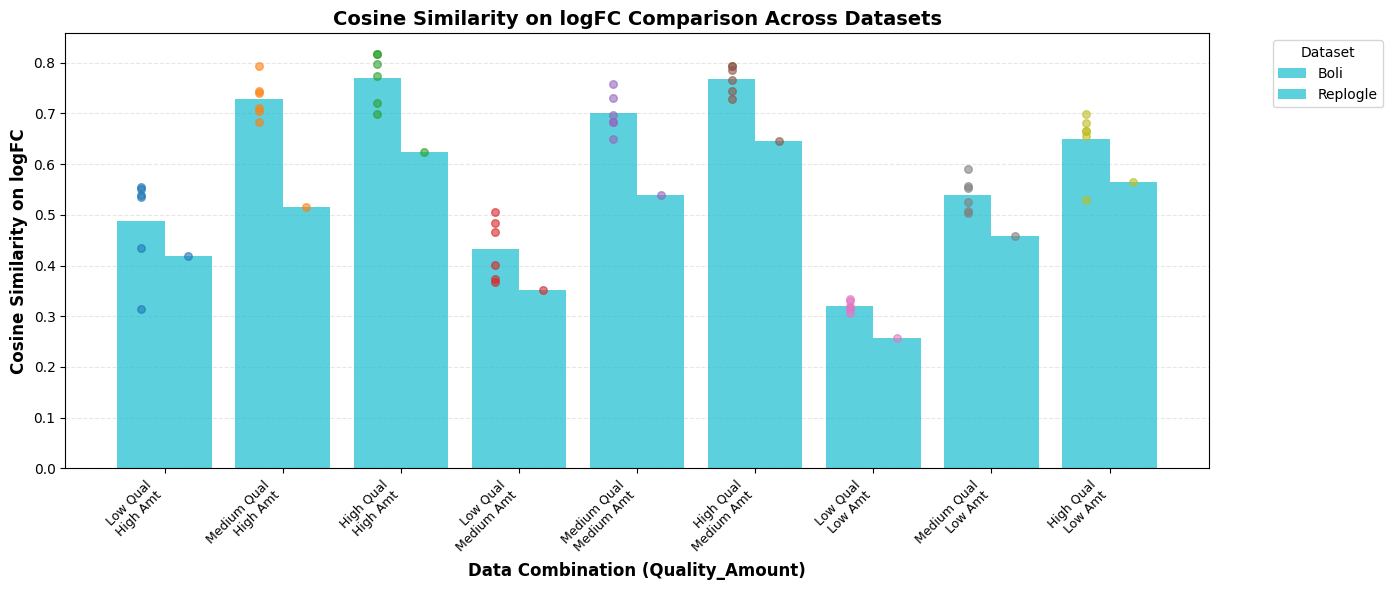

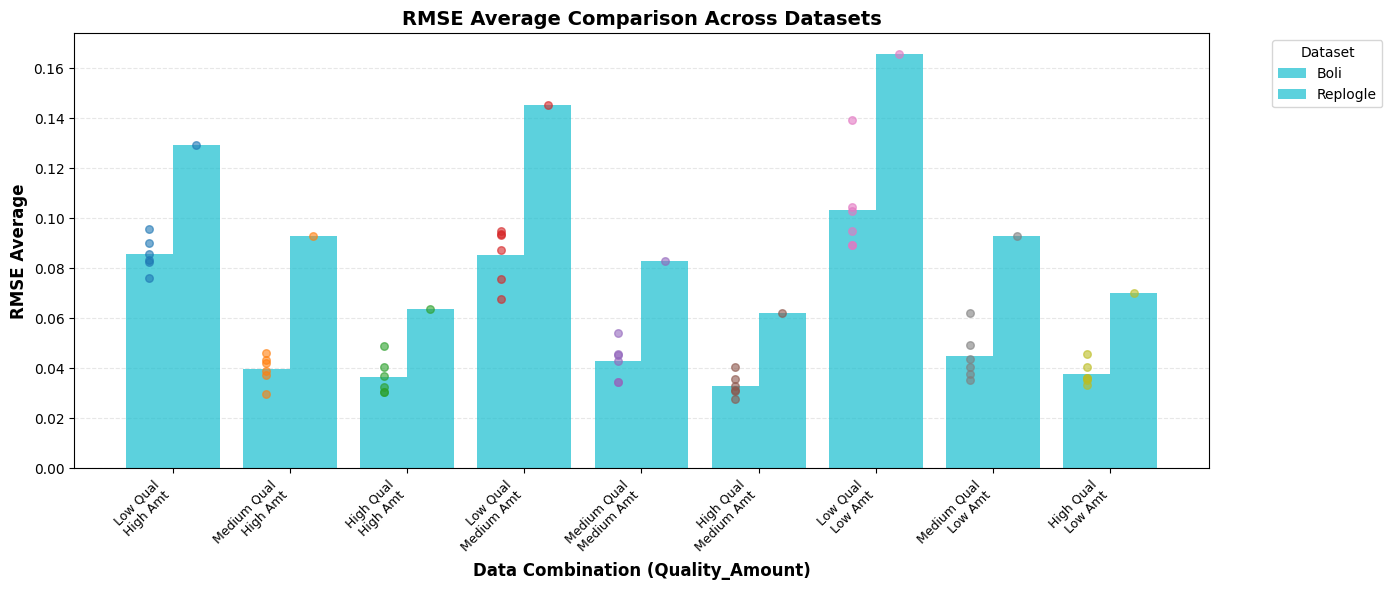

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------- CONFIGURE YOUR DATASETS HERE ----------
DATASETS = [
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_16-16-59/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_21-09-21/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_21-49-57/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_21-50-19/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_21-51-40/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/*_replogle*/",
        "label": "Replogle"
    }
    # Add more datasets here as needed
]

# --------- CONFIGURE YOUR GRID LABELS HERE ----------
x_labels = ["low", "medium", "high"]      # Training Data Amount
y_labels = ["high", "medium", "low"]      # Data Quality

# Optional: regex patterns for parsing
AMOUNT_RE  = re.compile(r"(?:amount|train|split|size|amt|data|cells)[-_]?(low|medium|high)", re.I)
QUALITY_RE = re.compile(r"(?:quality|qual|noise|q)[-_]?(low|medium|high)", re.I)

# --------- HELPERS ----------
def find_label_in_text(text, labels):
    """Return first matching label in `labels` found as whole word in text (case-insensitive)."""
    for lab in labels:
        if re.search(rf"\b{re.escape(lab)}\b", text, flags=re.I):
            return lab
    return None

def parse_xy_from_path(path):
    """
    Infer (x_amount, y_quality) from the run directory name.
    Tries explicit regex first; falls back to scanning labels in the path.
    """
    run_dir = os.path.dirname(path)
    base = os.path.basename(run_dir)

    m_amt = AMOUNT_RE.search(run_dir) or AMOUNT_RE.search(base)
    m_qual = QUALITY_RE.search(run_dir) or QUALITY_RE.search(base)

    x = (m_amt.group(1).lower() if m_amt else None)
    y = (m_qual.group(1).lower() if m_qual else None)

    # Fallbacks: try to spot labels anywhere in the path
    if x is None:
        x = find_label_in_text(run_dir, x_labels)
    if y is None:
        y = find_label_in_text(run_dir, y_labels)

    return x, y

def get_combination_label(amt, qual):
    """Create a readable label for the combination."""
    return f"{qual.capitalize()} Qual\n{amt.capitalize()} Amt"

# --------- LOAD DATA FROM ALL DATASETS ----------
all_data = []

for dataset in DATASETS:
    pattern = dataset["pattern"]
    dataset_label = dataset["label"]
    
    paths = sorted(glob.glob(pattern))
    
    for p in paths:
        csv_path = os.path.join(p, "evaluation/summary.csv")
        
        if not os.path.exists(csv_path):
            print(f"[warn] CSV not found: {csv_path}")
            continue
            
        x, y = parse_xy_from_path(csv_path)
        
        if (x not in x_labels) or (y not in y_labels):
            print(f"[warn] Could not map run to grid (x={x}, y={y}) for: {csv_path}")
            continue

        df = pd.read_csv(csv_path)
        
        if df.shape[1] < 2:
            print(f"[warn] Unexpected CSV shape for {csv_path}: {df.shape}")
            continue

        value_col = df.columns[1]
        sub = df.set_index("metric")[value_col]
        
        # Store the data
        data_point = {
            "dataset": dataset_label,
            "amount": x,
            "quality": y,
            "combination": f"{y}_{x}",
            "cosine_logfc": float(sub["cosine_logfc"]) if "cosine_logfc" in sub.index else np.nan,
            "rmse_average": float(sub["rmse_average"]) if "rmse_average" in sub.index else np.nan,
        }
        all_data.append(data_point)

# Convert to DataFrame
df_all = pd.DataFrame(all_data)

# --------- CREATE BAR GRAPHS ----------
def plot_metric_comparison(df, metric_name, ylabel):
    """Create a bar graph comparing datasets across all combinations."""
    
    # Create all possible combinations in order
    combinations = []
    for qual in y_labels:  # high, medium, low quality
        for amt in x_labels:  # low, medium, high amount
            combinations.append(f"{qual}_{amt}")
    
    # Calculate means and collect individual points for each combination and dataset
    plot_data = []
    for comb in combinations:
        for dataset_label in df["dataset"].unique():
            subset = df[(df["combination"] == comb) & (df["dataset"] == dataset_label)]
            values = subset[metric_name].dropna()
            
            if len(values) > 0:
                plot_data.append({
                    "combination": comb,
                    "dataset": dataset_label,
                    "mean": values.mean(),
                    "values": values.values
                })
    
    plot_df = pd.DataFrame(plot_data)
    
    if plot_df.empty:
        print(f"[warn] No data to plot for {metric_name}")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Set up x positions
    n_datasets = len(df["dataset"].unique())
    width = 0.8 / n_datasets
    x_pos = np.arange(len(combinations))
    
    # Plot bars and scatter points for each dataset
    for i, dataset_label in enumerate(df["dataset"].unique()):
        dataset_data = plot_df[plot_df["dataset"] == dataset_label]
        
        means = []
        positions = []
        
        for j, comb in enumerate(combinations):
            comb_data = dataset_data[dataset_data["combination"] == comb]
            if not comb_data.empty:
                means.append(comb_data["mean"].values[0])
                positions.append(j)
                
                # Scatter individual points
                values = comb_data["values"].values[0]
                x_scatter = np.full(len(values), j + (i - n_datasets/2 + 0.5) * width)
                ax.scatter(x_scatter, values, alpha=0.6, s=30, zorder=3)
        
        # Plot bars
        bar_positions = [p + (i - n_datasets/2 + 0.5) * width for p in positions]
        ax.bar(bar_positions, means, width, label=dataset_label, alpha=0.7, zorder=2)
    
    # Customize plot
    ax.set_xlabel("Data Combination (Quality_Amount)", fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(f"{ylabel} Comparison Across Datasets", fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([get_combination_label(*c.split('_')) for c in combinations], 
                        rotation=45, ha='right', fontsize=9)
    ax.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# --------- GENERATE PLOTS ----------
print(f"Loaded {len(df_all)} data points from {len(DATASETS)} datasets")
print(f"Datasets: {df_all['dataset'].unique()}")

plot_metric_comparison(df_all, "cosine_logfc", "Cosine Similarity on logFC")
plot_metric_comparison(df_all, "rmse_average", "RMSE Average")

[warn] CSV not found: /gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-08_18-10-15/0_replogle_251008_2_qual_high_amt_high/evaluation/summary.csv
Loaded 81 data points from 11 datasets
Datasets: ['Boli' 'Replogle']


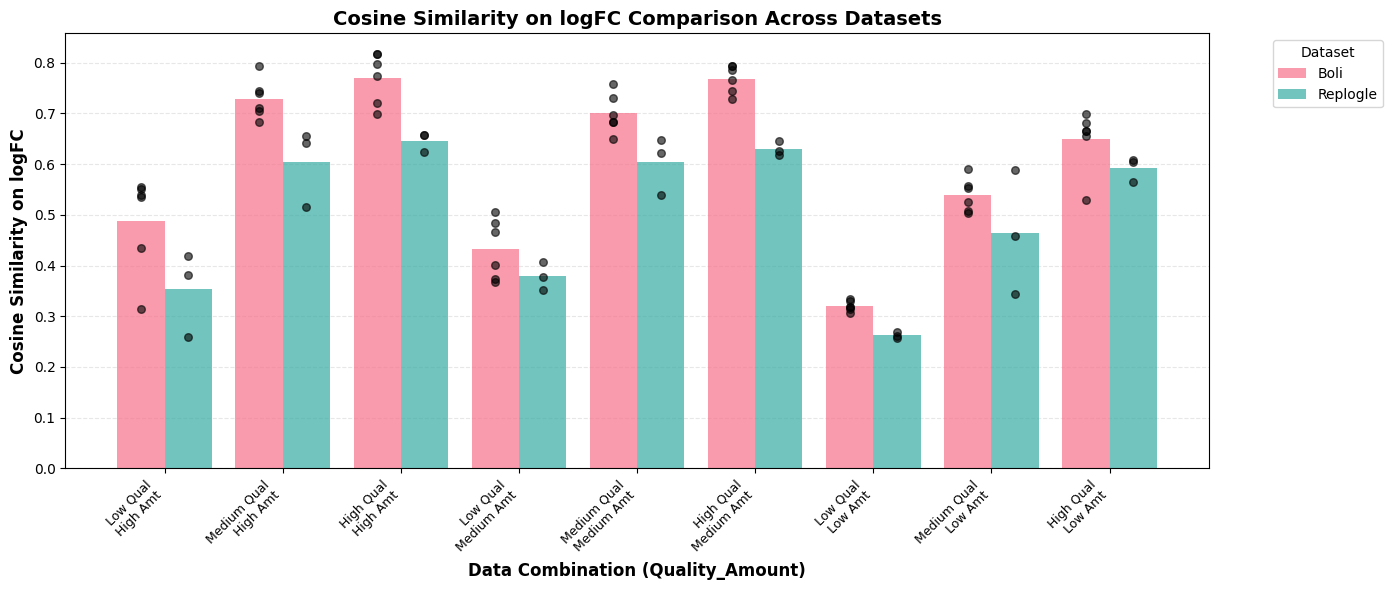

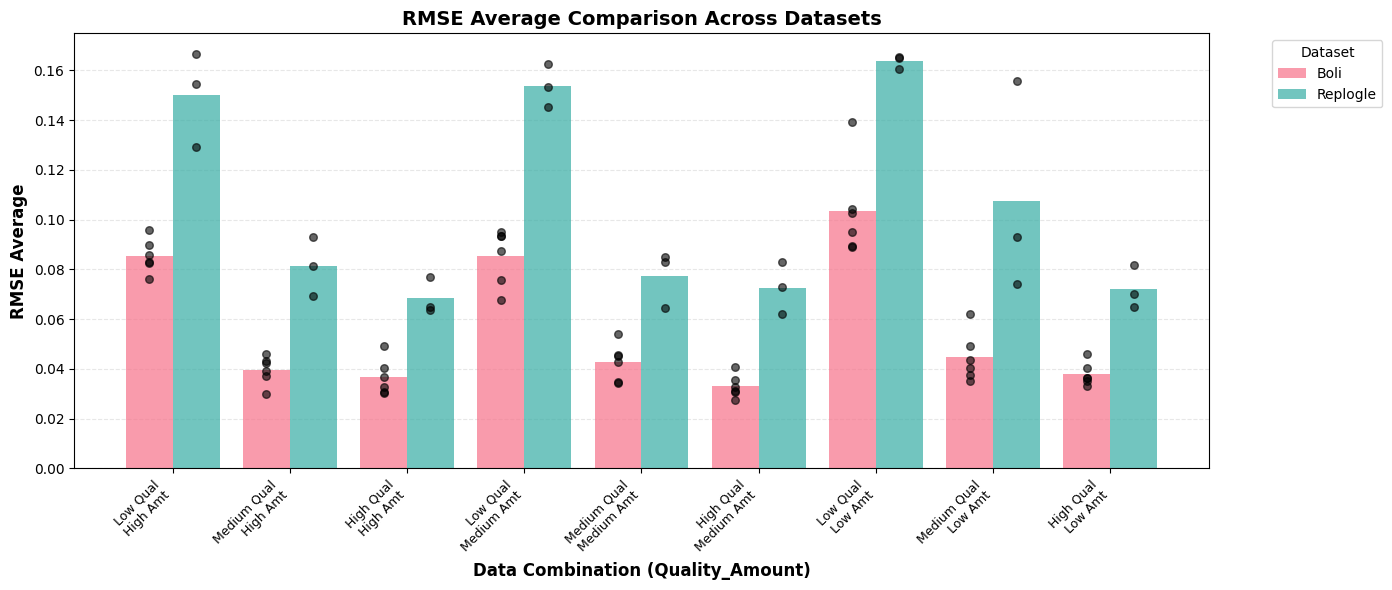

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATASETS = [
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-02_17-00-50/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_16-16-59/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_21-09-21/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_21-49-57/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_21-50-19/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-06_21-51-40/*boli*/",
        "label": "Boli"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_13-02-50/*_replogle*/",
        "label": "Replogle"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-08_18-10-15/*_replogle*/",
        "label": "Replogle"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-10-08_18-59-58/*_replogle*/",
        "label": "Replogle"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_19-34-06/*_replogle*/",
        "label": "Replogle"
    },
    {
        "pattern": "/gpfs/home/asun/jin_lab/perturbench/1_train/logs/train/multiruns/2025-09-23_19-35-29/*_replogle*/",
        "label": "Replogle"
    }
    # Add more datasets here as needed
]

# --------- CONFIGURE YOUR GRID LABELS HERE ----------
x_labels = ["low", "medium", "high"]      # Training Data Amount
y_labels = ["high", "medium", "low"]      # Data Quality

# Optional: regex patterns for parsing
AMOUNT_RE  = re.compile(r"(?:amount|train|split|size|amt|data|cells)[-_]?(low|medium|high)", re.I)
QUALITY_RE = re.compile(r"(?:quality|qual|noise|q)[-_]?(low|medium|high)", re.I)

# --------- HELPERS ----------
def find_label_in_text(text, labels):
    """Return first matching label in `labels` found as whole word in text (case-insensitive)."""
    for lab in labels:
        if re.search(rf"\b{re.escape(lab)}\b", text, flags=re.I):
            return lab
    return None

def parse_xy_from_path(path):
    """
    Infer (x_amount, y_quality) from the run directory name.
    Tries explicit regex first; falls back to scanning labels in the path.
    """
    run_dir = os.path.dirname(path)
    base = os.path.basename(run_dir)

    m_amt = AMOUNT_RE.search(run_dir) or AMOUNT_RE.search(base)
    m_qual = QUALITY_RE.search(run_dir) or QUALITY_RE.search(base)

    x = (m_amt.group(1).lower() if m_amt else None)
    y = (m_qual.group(1).lower() if m_qual else None)

    # Fallbacks: try to spot labels anywhere in the path
    if x is None:
        x = find_label_in_text(run_dir, x_labels)
    if y is None:
        y = find_label_in_text(run_dir, y_labels)

    return x, y

def get_combination_label(amt, qual):
    """Create a readable label for the combination."""
    return f"{qual.capitalize()} Qual\n{amt.capitalize()} Amt"

# --------- LOAD DATA FROM ALL DATASETS ----------
all_data = []

for dataset in DATASETS:
    pattern = dataset["pattern"]
    dataset_label = dataset["label"]
    
    paths = sorted(glob.glob(pattern))
    
    for p in paths:
        csv_path = os.path.join(p, "evaluation/summary.csv")
        
        if not os.path.exists(csv_path):
            print(f"[warn] CSV not found: {csv_path}")
            continue
            
        x, y = parse_xy_from_path(csv_path)
        
        if (x not in x_labels) or (y not in y_labels):
            print(f"[warn] Could not map run to grid (x={x}, y={y}) for: {csv_path}")
            continue

        df = pd.read_csv(csv_path)
        
        if df.shape[1] < 2:
            print(f"[warn] Unexpected CSV shape for {csv_path}: {df.shape}")
            continue

        value_col = df.columns[1]
        sub = df.set_index("metric")[value_col]
        
        # Store the data
        data_point = {
            "dataset": dataset_label,
            "amount": x,
            "quality": y,
            "combination": f"{y}_{x}",
            "cosine_logfc": float(sub["cosine_logfc"]) if "cosine_logfc" in sub.index else np.nan,
            "rmse_average": float(sub["rmse_average"]) if "rmse_average" in sub.index else np.nan,
        }
        all_data.append(data_point)

# Convert to DataFrame
df_all = pd.DataFrame(all_data)

# --------- CREATE BAR GRAPHS ----------
def plot_metric_comparison(df, metric_name, ylabel):
    """Create a bar graph comparing datasets across all combinations."""
    
    # Create all possible combinations in order
    combinations = []
    for qual in y_labels:  # high, medium, low quality
        for amt in x_labels:  # low, medium, high amount
            combinations.append(f"{qual}_{amt}")
    
    # Calculate means and collect individual points for each combination and dataset
    plot_data = []
    for comb in combinations:
        for dataset_label in df["dataset"].unique():
            subset = df[(df["combination"] == comb) & (df["dataset"] == dataset_label)]
            values = subset[metric_name].dropna()
            
            if len(values) > 0:
                plot_data.append({
                    "combination": comb,
                    "dataset": dataset_label,
                    "mean": values.mean(),
                    "values": values.values
                })
    
    plot_df = pd.DataFrame(plot_data)
    
    if plot_df.empty:
        print(f"[warn] No data to plot for {metric_name}")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Set up x positions
    n_datasets = len(df["dataset"].unique())
    width = 0.8 / n_datasets
    x_pos = np.arange(len(combinations))
    
    # Define color palette for different datasets
    colors = sns.color_palette("husl", n_datasets)
    
    # Plot bars and scatter points for each dataset
    for i, dataset_label in enumerate(df["dataset"].unique()):
        dataset_data = plot_df[plot_df["dataset"] == dataset_label]
        color = colors[i]
        
        means = []
        positions = []
        
        for j, comb in enumerate(combinations):
            comb_data = dataset_data[dataset_data["combination"] == comb]
            if not comb_data.empty:
                means.append(comb_data["mean"].values[0])
                positions.append(j)

                # Scatter individual points
                values = comb_data["values"].values[0]
                x_scatter = np.full(len(values), j + (i - n_datasets/2 + 0.5) * width)
                ax.scatter(x_scatter, values, alpha=0.6, s=30, color='black', zorder=3)
        
        # Plot bars
        bar_positions = [p + (i - n_datasets/2 + 0.5) * width for p in positions]
        ax.bar(bar_positions, means, width, label=dataset_label, color=color, alpha=0.7, zorder=2)
    
    # Customize plot
    ax.set_xlabel("Data Combination (Quality_Amount)", fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(f"{ylabel} Comparison Across Datasets", fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([get_combination_label(*c.split('_')) for c in combinations], 
                        rotation=45, ha='right', fontsize=9)
    ax.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# --------- GENERATE PLOTS ----------
print(f"Loaded {len(df_all)} data points from {len(DATASETS)} datasets")
print(f"Datasets: {df_all['dataset'].unique()}")

plot_metric_comparison(df_all, "cosine_logfc", "Cosine Similarity on logFC")
plot_metric_comparison(df_all, "rmse_average", "RMSE Average")